# AnyoneAI - Final Project
> Hospitalization Prediction for Elderly Population

The project aims to predict the probability of hospitalization for elderly Mexican individuals using machine learning algorithms and data such as demographics, health indicators, and medical history. The model can help healthcare providers identify high-risk patients and allocate resources accordingly. This project is similar to what you have implemented in the last few sprints but with a focus on building a model that can use a few features to make accurate predictions.

### Goal:
The main goal of this project is to ask users to complete a form and use the provided information to predict the risk of hospitalization for that person in the next year. For that task, a Machine Learning model must be trained to make that prediction. Keep in mind the dataset we are going to use has thousands of features but, we can't ask users to complete such amount of fields in the form. We suggest you start using some classic models like Decision Trees, Random Forests, or Gradient Boosting, identify the most important features, and try to refine your model input based on that.

### Main Deliverables:
- Exploratory Dataset Analysis (EDA)
- Scripts used for data pre-processing and data preparation
- Training scripts and trained models. Description of how to reproduce results
- Implementation and training of model for hospitalization prediction
- The final model should need less than 50 features to make predictions
- The final model AUC Score must be over 0.9
- Present results and a demo of the model doing predictions in real time using an API
- Everything must be containerized using Docker

### Additional Optional Deliverables:
- Experiment using Transformer models, you can convert the data to a string, experiment using certain subsets of features, and evaluate how good are the predictions with few input variables.
- Make a UI in which users must complete a form to get the prediction for the demo.

In [1]:
# Standard Library Imports
import os
from collections import Counter

# Third-Party Library Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import joblib

# Local Imports
from src import config, data_utils, data_eda, preprocessing

# Suppressing Warnings
# import warnings
# warnings.filterwarnings("ignore")

## 1. Introduction
The dataset comprises multiple files with information about aging, health, and retirement from the Mexican Family of Health and Retirement surveys:
`H_MHAS_c2.sas7bdat`, `H_MHAS_EOL_b.sas7bdat`  and `H_MEX_COG_A2_2016.dta`. <br>
In this section, we will load the data corresponding to the `H_MHAS_c2.sas7bdat` file and perform a manual filtering of all features based on apriori knowledge of the problem to be solved.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download one sas7bdat file inside the `dataset` folder:

- `H_MHAS_c2.sas7bdat`: The MHAS Dataset is public and free of charge for use but you will have to register on their website to get full access. You can see all the available data in the following link: https://www.mhasweb.org/DataProducts/HarmonizedData.aspx. This file consolidates information throughout the survey duration and is linked by user ID.

In [2]:
h_mhas_c2 = data_utils.get_datasets()

In [3]:
print('In our dataset we have',h_mhas_c2.shape[0],'subjects')
print('In our dataset we have',h_mhas_c2.shape[1],'features')

In our dataset we have 26839 subjects
In our dataset we have 5241 features


### Data and Features
The dataset `H_MHAS_c2.sas7bdat` has 26839 rows and 5241 features.

All features are divided into the following sections.

- SECTION A: DEMOGRAPHICS, IDENTIFIERS, AND WEIGHTS (251 features)
- SECTION B: HEALTH (1624 features)
- SECTION C: HEALTH CARE UTILIZATION AND INSURANCE  (236 features)
- SECTION D: COGNITION  (706 features)
- SECTION E: FINANCIAL AND HOUSING WEALTH (148 features)
- SECTION F: INCOME (212 features)
- SECTION G: FAMILY STRUCTURE (223 features)
- SECTION H: EMPLOYMENT HISTORY (110 features)
- SECTION I: RETIREMENT (16 features)
- SECTION J: PENSION (54 features)
- SECTION K: PHYSICAL MEASURES (282 features)
- SECTION L: ASSISTANCE AND CAREGIVING (1103 features)
- SECTION M: STRESS (77 features)
- SECTION O: END OF LIFE PLANNING (33 features)
- SECTION Q: PSYCHOSOCIAL (166 features)

<b> SOME IMPORTANT INSIGHTS </b><br>
Data can be obtained at the link: https://www.mhasweb.org/DataProducts/HarmonizedData.aspx. in different formats.
-   `H_MHAS_c2.sas7bdat` (downloaded for our project 470 MB)-> The disk size is larger, but it contains the data already coded and checked against the documentation, which allows easier data analysis.
-   `H_MHAS_c2.sav` (166 MB) and `H_MHAS_c2.dta` (176 MB)-> smaller size but mostly categorical variables, which makes conversion and analysis more difficult.

In [4]:
h_mhas_c2.dtypes.value_counts()

float64    5234
object        7
dtype: int64

Since 7 features are categorical, we reviewed the data and realized that it is possible to transform all 14 variables to numerical.

In [5]:
categorical_vars = h_mhas_c2.select_dtypes(include=['object']).columns
numerical_vars = h_mhas_c2.select_dtypes(include=['float64']).columns

print('We have ' + str(len(categorical_vars)) + ' categorical features in our dataset')
print('We have ' + str(len(numerical_vars)) + ' numerical features in our dataset')
print('We need to check if we can convert the following to numerical: ')
print(categorical_vars)

We have 7 categorical features in our dataset
We have 5234 numerical features in our dataset
We need to check if we can convert the following to numerical: 
Index(['rahhidnp', 'h1hhidc', 'h2hhidc', 'h3hhidc', 'h4hhidc', 'h5hhidc',
       'acthog'],
      dtype='object')


<b> SOME IMPORTANT INSIGHTS </b>
-   The first character of the majority of variables indicates whether the variable refers to the reference person (“r”), spouse (“s”), or household (“h”).
-   The second character indicates the wave to which the variable pertains: “1”, “2”, “3”, “4”, “5”, or “A”. The “A” indicates “all,”

In [6]:
starts_with_s = sum(col.startswith('s') for col in h_mhas_c2.columns)
starts_with_r = sum(col.startswith('r') for col in h_mhas_c2.columns)
starts_with_h = sum(col.startswith('h') for col in h_mhas_c2.columns)

print(f"Number of columns starting with 's' from spouse: {starts_with_s}")
print(f"Number of columns starting with 'r' from reference: {starts_with_r}")
print(f"Number of columns starting with 'h' from household: {starts_with_h}")

Number of columns starting with 's' from spouse: 2457
Number of columns starting with 'r' from reference: 2398
Number of columns starting with 'h' from household: 354


Below are some tables with the division of the subsections included in the survey of the elderly.

- SECTION A - This section consists of 26 subsections (245 features)
- SECTION B - This section consists of 27 subsections (1624 features)
- SECTION L - This section consists of 31 subsections (1103 features)

| A - DEMOG,   IDENTIFIERS, AND WEIGHTS                  | B - HEALTH                                                           | L - ASSISTANCE AND CAREGIVING                                       |
|--------------------------------------------------------|----------------------------------------------------------------------|---------------------------------------------------------------------|
| <b> ` Person Specific Identifier `   </b>              | Self-Report of Health                                                | ADL Help                                                            |
| <b> ` Household Identifier `   </b>                    | Activities of Daily Living (ADLs): Raw Recodes                       | IADL Help                                                           |
| <b> ` Spouse Identifier `   </b>                       | Activities of Daily Living (ADLs): Some Difficulty                   | Whether Uses Personal Aids                                          |
| <b> ` Wave Status: Response   Indicator ` </b>         | Instrumental Activities of Daily Living (IADLs): Raw Recodes         | Future ADL Help                                                     |
| Wave Status: Interview Status                          | Instrumental Activities of Daily Living (IADLs): Some Difficulty     | ADL: Whether Receives Any Care                                      |
| <b> ` Sample Cohort `   </b>                           | Other Functional Limitations: Raw Recodes                            | ADL: Whether Receives Any Informal Care                             |
| <b> ` Whether Proxy Interview `   </b>                 | Other Functional Limitations: Some Difficulty                        | ADL: Receives Informal Care from Spouse                             |
| Number of Household Respondents                        | <b> ` ADL Summary: Sum ADLs Reports Any Difficulty `   </b>          | ADL: Receives Informal Care from Children or Grandchildren          |
| Whether Couple Household                               | <b> ` IADL Summary: Sum IADLs Reports Any Difficulty `   </b>        | ADL: Receives Informal Care from Relatives                          |
| <b> ` Household Analysis Weight `   </b>               | Other Summary Indices: Mobility, Large Muscle, Gross, etc.           | ADL: Receives Informal Care from Other Individuals                  |
| <b> ` Person-Level Analysis Weight   ` </b>            | Doctor Diagnosed Health Problems: Ever Have Condition                | ADL: Whether Receives Any Formal Care                               |
| Interview Dates                                        | Doctor Diagnosed Diseases: Receives Treatment or Medic for Disease   | ADL: Receives Formal Care from Paid Professional                    |
| Birth Date: Month and Year                             | Doctor Diagnosed Diseases: Whether Disease Limits Activity           | IADL: Whether Receives Any Care                                     |
| <b> ` Death Date: Month and Year `   </b>              | Doctor Diagnosed Diseases: Age of Diagnosis                          | IADL: Whether Receives Any Informal Care                            |
| Age at Interview (Months and Years)                    | Vision                                                               | IADL: Receives Informal Care from Spouse                            |
| Gender                                                 | Hearing                                                              | IADL: Receives Informal Care from Children or Grandchildren         |
| Education                                              | Falls                                                                | IADL: Receives Informal Care from Relatives                         |
| Education: Categories by ISCED Codes                   | Urinary Incontinence                                                 | IADL: Receives Informal Care from Other Individuals                 |
| Education: Harmonized Education                        | Persistent Health Problems                                           | IADL: Whether Receives Any Formal Care                              |
| <b> ` Literacy and Numeracy `   </b>                   | <b> ` Sleep ` </b>                                                   | IADL: Receives Formal Care from Paid Professional                   |
| Indigenous Language                                    | Pain                                                                 | ADL and IADL: Whether Receives Any Care                             |
| Current Marital Status: Current   Partnership Status   | <b> ` Menopause ` </b>                                               | ADL and IADL: Whether Receives Any Informal Care                    |
| Current Marital Status: With Partnership               | BMI                                                                  | ADL and IADL: Receives Informal Care from Spouse                    |
| Current Marital Status: Without   Partnership          | Health Behaviors: Physical Activity or Exercise                      | ADL and IADL: Receives Informal Care from Children or Grandchildren |
| Number of Marriages                                    | Health Behaviors: Drinking                                           | ADL and IADL: Receives Informal Care from Relatives                 |
| Urban or Rural                                         | Health Behaviors: Smoking (Cigarettes)                               | ADL and IADL: Receives Informal Care from Other Individuals         |
|                                                        | <b> ` Health Behaviors: Preventive Care `   </b>                     | ADL and IADL: Whether Receives Any Formal Care                      |
|                                                        |                                                                      | ADL and IADL: Receives Formal Care from Paid Professional           |
|                                                        |                                                                      | Receives Help with Chores from Children or Grandchildren            |
|                                                        |                                                                      | Provides Informal Care to Children or Grandchildren                 |
|                                                        |                                                                      | Provides Personal Care to Parents                                   |
|                                                        |                                                                      | Provides Informal Care for Sick or Disabled Adults                  |

- SECTION D - This section consists of 15 subsections (706 features)
- SECTION E - This section consists of 15 subsections (148 features)
- SECTION G - This section consists of 19 subsections (223 features)

| D: COGNITION                                        | E - FINANCIAL AND HOUSING WEALTH                                      | G - FAMILY STRUCTURE                        |
|-----------------------------------------------------|-----------------------------------------------------------------------|---------------------------------------------|
| Cognition Testing Conditions                        | <b> ` Inflation Multiplier  `   </b>                                  | Number of People Living in Household        |
| Self-Reported Memory                                | <b> ` Net Value of Real Estate (Not Primary Residence)  ` </b>        | Number of Living Children                   |
| Immediate Word Recall                               | <b> ` Net Value of Cars  `   </b>                                     | Number of Deceased Children                 |
| Delayed Word Recall                                 | <b> ` Net Value of Businesses    ` </b>                               | Number of Children Ever Born                |
| Summary Scores                                      | <b> ` Value of Stocks Shares and Bonds  ` </b>                        | Number of Grandchildren                     |
| Picture Drawing                                     | <b> ` Value of Checking Savings Accounts  ` </b>                      | Number of Living Siblings                   |
| Verbal Fluency                                      | <b> ` Value of Other Assets    ` </b>                                 | Number of Deceased Siblings                 |
| Visual Scanning                                     | <b> ` Value of Primary Residence    ` </b>                            | Number of Living Parents                    |
| Backwards Counting From 20                          | <b> ` Value of All Mortgages (Primary Residence)  ` </b>              | Parental Mortality                          |
| <b> ` Date Naming/Orientation    ` </b>             | <b> ` Net Value of Primary Residence  ` </b>                          | Parents' Current Age or Age at Death        |
| Serial 7’s                                          | <b> ` Home ownership  `   </b>                                        | Parents' Education                          |
| <b> ` Proxy Cognition: JORM IQCODE    ` </b>        | <b> ` Value of Other Debt  `   </b>                                   | Any Child Co-Resides with Respondent        |
| Proxy Cognition: Ratings of Memory and   Abilities  | <b> ` Value of Loans Lent  `   </b>                                   | Any Children Living in the Same City        |
| Proxy Cognition: Cognitive   Impairment             | <b> ` Net Value of Non-Housing Finan Wealth (Excluding IRAs)  ` </b>  | Any Weekly Contact with Children            |
| Proxy Cognition: Problem Behaviors in   Past Week   | Total Wealth                                                          | Freq/ Weekly Contact Relatives and Friends  |
|                                                     |                                                                       | <b> ` W Soc Activ/Partic Religious `   </b> |
|                                                     |                                                                       | Financial Transfer from Children            |
|                                                     |                                                                       | Financial Transfer to Children              |
|                                                     |                                                                       | Financial Transfer to Parents               |

- SECTION H - This section consists of 12 subsections (110 features)
- SECTION K - This section consists of 8 subsections (282 features)
- SECTION F - This section consists of 10 subsections (212 features)

| H - EMPLOYMENT   HISTORY                                           | K - PHYSICAL MEASURES                                                              | F - INCOME                                                       |
|--------------------------------------------------------------------|------------------------------------------------------------------------------------|------------------------------------------------------------------|
| <b> ` Currently Working for Pay `   <b>                            | Height, Weight, Waist and Hip Circumference Measurements                           | <b> ` Individual Earnings  `   </b>                              |
| <b> ` Whether Self-Employed `   <b>                                | Height, Weight, Waist and Hip Circumference Measurements: Reason Didn't   Complete | <b> ` Household Capital Income    ` </b>                         |
| <b> ` Labor Force Status `   <b>                                   | <b> ` Sitting Height ` <b>                                                         | <b> ` Individual Income from Private Pension  ` </b>             |
| <b> ` In the Labor Force `   <b>                                   | <b> ` Sitting Height: Reason Didn't Complete ` <b>                                 | <b> ` Individual Public Pension Income  ` </b>                   |
| Unemployment Status                                                | Balance Test                                                                       | <b> ` Individual Other Pensions Income  ` </b>                   |
| <b> ` Retired Employment Status `   <b>                            | Balance Test: Reason Didn't Complete                                               | <b> ` Individual Total Pensions Income  ` </b>                   |
| <b> ` Hours at Main Job ` <b>                                      | <b> ` Blood Pressure Measurements ` <b>                                            | <b> ` Individual Income from Other Government Transfers  ` </b>  |
| <b> ` Main Activity Years of Tenure   ` <b>                        | <b> ` Blood Pressure Measurements: Reason Didn't Complete `   <b>                  | <b> ` All Other Income  `   </b>                                 |
| <b> ` Job Allows Move to Less   Demanding Work ` <b>               | <b> ` Timed Walk Measurements ` <b>                                                | Total Household Income (respondent & spouse)                     |
| <b> ` Occupation Code for Job with   Longest Reported Tenure ` <b> | <b> ` Timed Walk Measurements: Reason Didn't Complete ` <b>                        | Total Household Consumption (full household)                     |
| Year Last Job Ended                                                | <b> ` Hand Grip Strength Measurements ` <b>                                        |                                                                  |
| Reason Job Ended                                                   | <b> ` Hand Grip Strength Measurements: Reason Didn't Complete `   <b>              |                                                                  |

- SECTION J - This section consists of 7 subsections (54 features)
- SECTION C - This section consists of 8 subsections (236 features)
- SECTION I - This section consists of 2 subsections (16 features)

| J - PENSION                                                   | C - HEALTH CARE UTILIZATION AND INSURANCE                  | I - RETIREMENT                                                   |
|---------------------------------------------------------------|------------------------------------------------------------|------------------------------------------------------------------|
| <b> ` Whether Receives Public   Pension ` </b>                | Medical Care Utilization: Hospital                         | <b> ` Whether Retired: Retirement year, if says retired `   </b> |
| <b> ` Whether Receives Private   Pension ` </b>               | Medical Care Utilization: Doctor                           | Whether Retired: Retirement age, if says retired                 |
| <b> ` Whether Receives Other   Pension ` </b>                 | Medical Care Utilization: Other Medical Care Utilization   |                                                                  |
| <b> ` Age When Started to Receive a   Public Pension ` </b>   | <b> ` Medical Expenditures: Out of Pocket and Total ` </b> |                                                                  |
| <b> ` Age When Started to Receive a   Private Pension ` </b>  | <b> ` Cov Federal Gov Health Insurance Program ` </b>      |                                                                  |
| <b> ` Whether Current Public   Pension(s) Can Continue ` </b> | <b> ` Cov Priv Health Insurance ` </b>                     |                                                                  |
| <b> ` Whether Current Private   Pension Can Continue ` </b>   | <b> ` Cov Health Insurance Curr/Previous Employer ` </b>   |                                                                  |
|                                                               | Number of Health Insurance Plans                           |                                                                  |

- SECTION M - This section consists of 4 subsections (77 features)
- SECTION O - This section consists of 3 subsections (33 features)
- SECTION Q - This section consists of 8 subsections (166 features)

| M - STRESS                   | O - END OF LIFE PLANNING                 | Q - PSYCHOSOCIAL                  |
|------------------------------|------------------------------------------|-----------------------------------|
| Social Support: Spouse       | <b> ` Will: Whether Has a Will ` </b>    | Depressive Symptoms: CESD         |
| Social Support: Children     | <b> ` Will: Beneficiaries of Will ` </b> | Satisfaction with Life Scale      |
| Social Support: Friends      | <b> ` Covered by Life Insurance ` </b>   | Single Life Satisfaction Question |
| Experienced Death of a Child |                                          | <b> ` Cantril Ladder ` </b>       |

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

### Loading of relevant features
Now that we know which characteristics are the most important for our project, we generate a data frame only with the columns of interest; in the same way, we will unify all the waves (five in total) of different data in one, considering that they are various interviews. Therefore, they can be handled as other subjects.

In [7]:
# Read the 'Features' sheet from the excel file
df_excel = pd.read_excel('./Feature Screening Document.xlsx', sheet_name='Sections')

# Columns whose values are intended to estimate missing or imputed values are eliminated.
elimins = df_excel[df_excel['CANDIDATETOINCLUDE']=='NO']['DICTIONARY NAME'].tolist()

# elimins

With the list stored in the variable elimins, we eliminate all the columns that are part of these subsections.

In [8]:
h_mhas_c2 = data_utils.remove_unnecessary_columns(h_mhas_c2, elimins)

h_mhas_c2.shape

(26839, 3706)

We will now also be able to unify the questions asked in the five waves and group them into a single list. This significantly reduces the number of features and increases the number of respondents (rows).

In [9]:
h_mhas_c2 = data_utils.concat_waves(h_mhas_c2)

h_mhas_c2.shape

#h_mhas_c2.columns

(268390, 451)

We identify the target variable as RXHOSP1Y - TARGET indicates whether the respondent reports having spent at least one night in the hospital in the last 12 months. TARGET is coded as 0 if the respondent has not spent any night in the hospital and as 1 if he/she has spent at least one night in the hospital.

In [10]:
# Identify the variable named 'rXhosp1y' and rename it to 'Target'
h_mhas_c2.rename(columns={'hosp1y': 'TARGET'}, inplace=True)

# Delete all rows where the variable 'Target' is equal to null
h_mhas_c2.dropna(subset=['TARGET'], inplace=True)

h_mhas_c2.shape

(124363, 451)

Finally, we save the dataset in a .csv file to have it available and not have to perform this procedure every time we open the notebook.

In [11]:
h_mhas_c2.to_csv(config.DATASET_TRAIN, index=False)

## 2. Exploratory Data Analysis EDA
In this stage, we will perform the exploratory data analysis (EDA) on our data frame. For this, we will include some of the essential techniques that will allow us not only to understand the structure of the data and summarize its main characteristics but also to give us a better understanding of the training model we will apply in the preprocessing. Let's take a look at some variables of interest that can be useful for further analysis and data processing.

### <b> WARNING: </b>
The following code has been created to avoid having to perform part 1 of this notebook. Therefore, you are suggested to load only the libraries before running it to load the debugged data frame.

In [12]:
# Run the following code only if you want to start from here.
app_train = data_utils.get_datatrain()

In [13]:
app_train.head()

,mwaist,enlife,slfmem,hip,iftot,drinknr,cagem,wstref,rpfcaren,sita,...,racany,fcany,fineaa,rxarthr,fallnum,rfcarehrm,painfr,urina2y,rifcare,child
0,NaN,0.0,5.0,NaN,0.0,NaN,4.0,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,1.0,NaN,1.0,0.0,NaN,5.0
1,NaN,1.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,5.0
2,NaN,1.0,4.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,...,NaN,1.0,0.0,0.0,1.0,NaN,1.0,0.0,NaN,6.0
3,NaN,1.0,NaN,NaN,0.0,NaN,4.0,NaN,NaN,0.0,...,NaN,1.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,6.0
4,NaN,0.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,1.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,4.0


### TARGET VARIABLE

As the first part of the EDA, we will analyze the target variable.

Target Variable Distribution:
0.0    109722
1.0     14641
Name: TARGET, dtype: int64

Percentage of Each Value:
0.0    88.2
1.0    11.8
Name: TARGET, dtype: float64


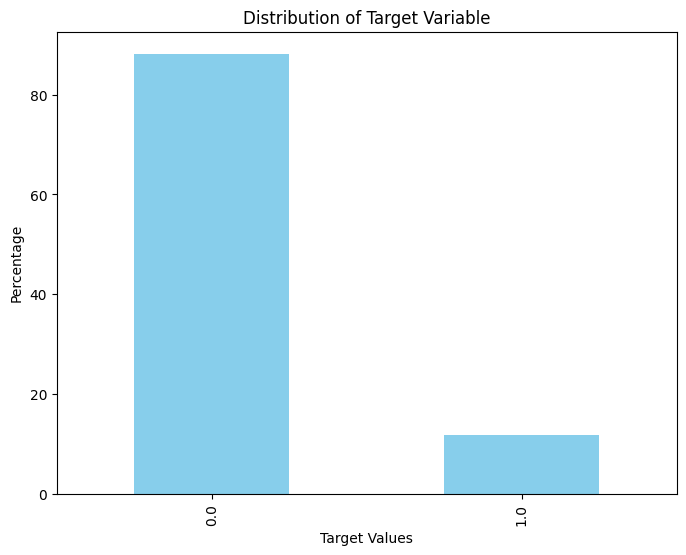

In [14]:
target_distribution = app_train.TARGET.value_counts()

# Print total value count and percentage of each value
print("Target Variable Distribution:")
print(target_distribution)
print("\nPercentage of Each Value:")
print(round(target_distribution/app_train.shape[0] * 100,1))

# Plot the distribution
plt.figure(figsize=(8, 6))
(target_distribution/app_train.shape[0] * 100).plot(kind='bar', color='skyblue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Values')
plt.ylabel('Percentage')
plt.show()

As expected, the target variable is quite unbalanced.

### AGE VALUES
The age variable is compared with the target variable; this allows us to check a deviation relative to hospitalized subjects versus those who have not been hospitalized.


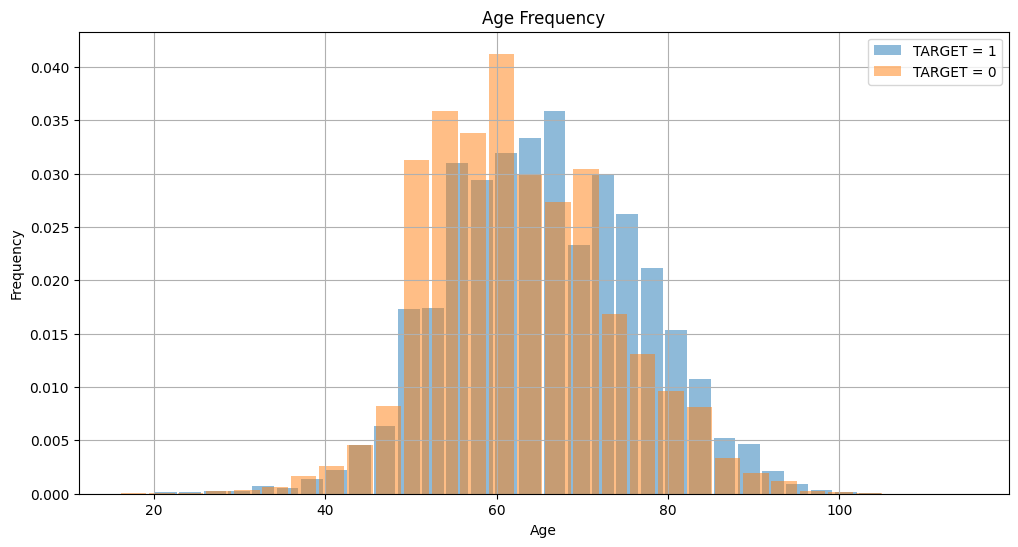

In [15]:
# Copy DataFrame where 'TARGET' equals 1
df1 = app_train[app_train['TARGET'] == 1].copy()

# Copy DataFrame where 'TARGET' equals 0
df0 = app_train[app_train['TARGET'] == 0].copy()

plt.figure(figsize=(12,6))

# Plot histogram for df1 using 'rXagey' column, with normalization
df1['agey'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 1', density=True)

# Plot histogram for df0 using 'rXagey' column, with normalization
df0['agey'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 0', density=True)

plt.title('Age Frequency')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right') # Add a legend
plt.show()

### DOCTOR VISITS
The DOCTOR1Y indicates whether the respondent reports at least one doctor visit in the last 12 months. The variable indicates that the majority of people who have been hospitalized previously made a greater number of visits to the doctor than those who were not hospitalized.

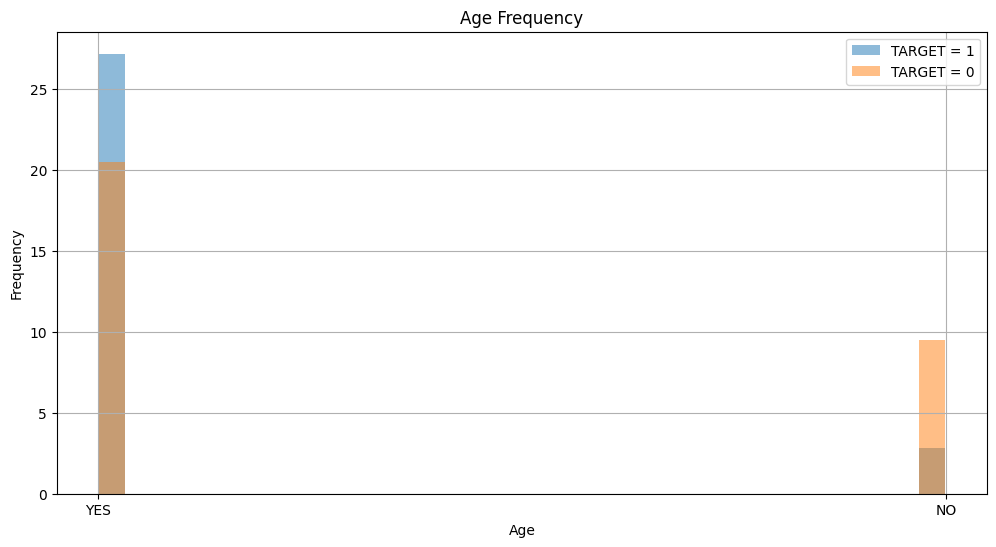

In [16]:
# Copy DataFrame where 'TARGET' equals 1
df1 = app_train[app_train['TARGET'] == 1].copy()

# Copy DataFrame where 'TARGET' equals 0
df0 = app_train[app_train['TARGET'] == 0].copy()

# Convert 'doctor1y' column to categorical
df1['doctor1y'] = df1['doctor1y'].replace({0: 'NO', 1: 'YES'})
df0['doctor1y'] = df0['doctor1y'].replace({0: 'NO', 1: 'YES'})

plt.figure(figsize=(12,6))

# Plot histogram for df1 using 'doctor1y' column, with normalization
df1['doctor1y'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 1', density=True)

# Plot histogram for df0 using 'doctor1y' column, with normalization
df0['doctor1y'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 0', density=True)

plt.title('Age Frequency')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right') # Add a legend
plt.show()

### NUMBER OF FALLS
FALLNUM indicates the number of times the respondent has fallen down. Although it is not an exact number, we can see in the graph the greater tendency of hospitalization in people who have been hospitalized versus those who have not.


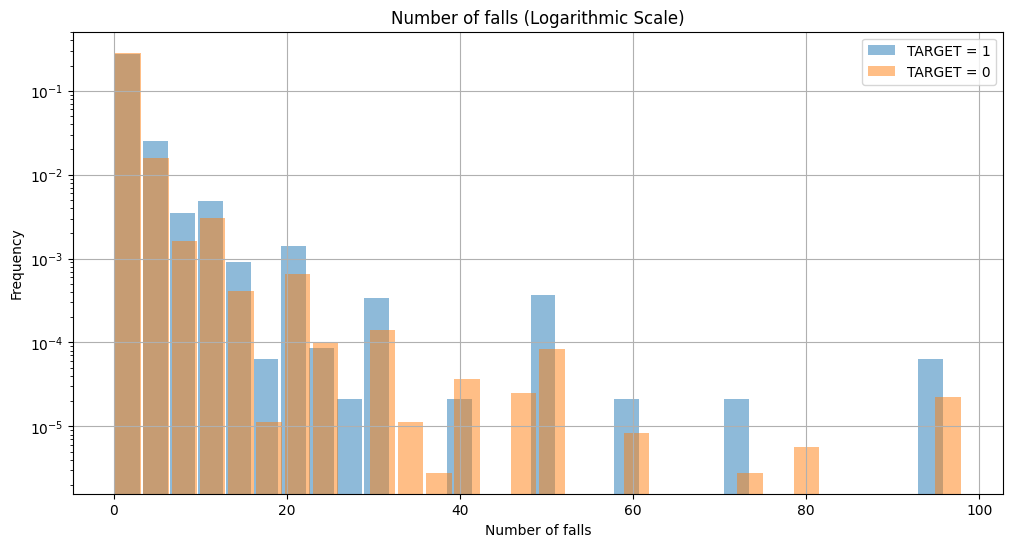

In [17]:
# Copy DataFrame where 'TARGET' equals 1
df1 = app_train[app_train['TARGET'] == 1].copy()

# Copy DataFrame where 'TARGET' equals 0
df0 = app_train[app_train['TARGET'] == 0].copy()

plt.figure(figsize=(12,6))

# Plot histogram for df1 using 'fallnum' column, with normalization
df1['fallnum'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 1', density=True, log=True)

# Plot histogram for df0 using 'fallnum' column, with normalization
df0['fallnum'].hist(rwidth=0.9, bins=30, alpha=0.5, label='TARGET = 0', density=True, log=True)

plt.title('Number of falls (Logarithmic Scale)')
plt.xlabel('Number of falls')
plt.ylabel('Frequency')
plt.legend(loc='upper right') # Add a legend
plt.show()

### HIGHLY CORRELATED VARIABLES
Many of the variables may be highly correlated; this is not appropriate for the model and should be eliminated.

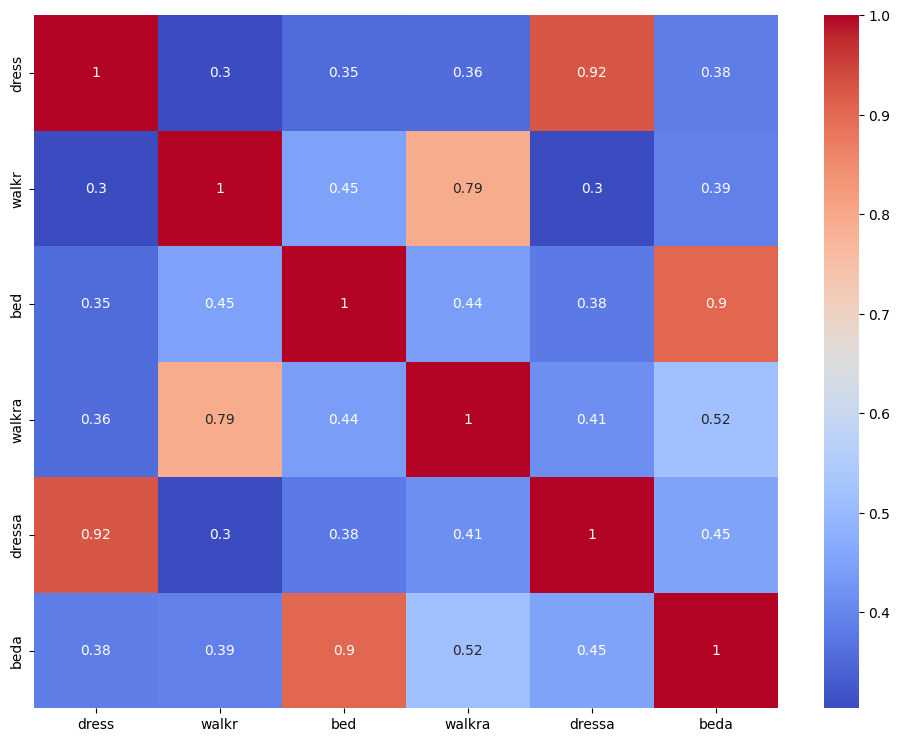

In [18]:
# Person Specific Identifier
# Self-Report of Health
Health2 =['dress', 'walkr', 'bed', 'walkra', 'dressa', 'beda']

# Assume df is your DataFrame
correlation_matrix = app_train[Health2].corr(numeric_only=True)

plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### NULL VALUES
A critical study in this phase is the search for null values. However, we indeed have many features to analyze, and several of them could contain a high percentage of null data, which is counterproductive for the analysis and subsequent training of our model.

Text(0, 0.5, 'Variable Name')

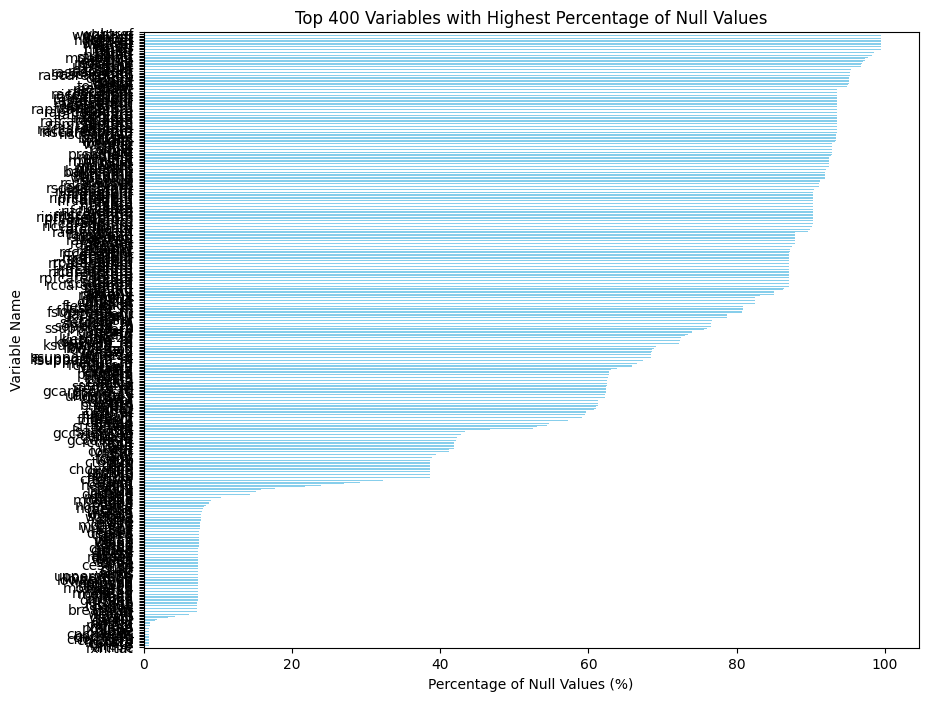

In [19]:
# Calculate total number of rows in the DataFrame
total_rows = len(app_train)

# Calculate number of null values for each variable
null_counts = app_train.isnull().sum()

# Calculate percentage of null values for each variable
null_percentage = (null_counts / total_rows) * 100

# Sort variables based on percentage of null values in descending order
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Select top N variables with highest percentage of null values
top_n = 400  # Adjust the value of N as needed
top_null_percentage = null_percentage_sorted.head(top_n)

# Plot variable names vs percentage of null values using horizontal bar chart
plt.figure(figsize=(10, 8))
top_null_percentage.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top {} Variables with Highest Percentage of Null Values'.format(top_n))
plt.xlabel('Percentage of Null Values (%)')
plt.ylabel('Variable Name')

As can be seen in the graph below, there are many features with a high number of null values, so our strategy will be based on eliminating these features. 

In [20]:
# Calculate the percentage of missing data for each column
total_values = app_train.isnull().sum()

missing_percentage = round((total_values / len(app_train)) * 100,1)

# Create a DataFrame to store the results
missing_data_df = pd.DataFrame({
    'Total': total_values,
    'Missing Percentage': missing_percentage
})

# Sort the DataFrame by missing percentage in descending order
missing_data_df = missing_data_df.sort_values(by='Missing Percentage', ascending=False)

# Display the top 20 columns with higher missing percentage
top_missing_columns = missing_data_df.head(10)
print("Top 20 columns with higher missing percentage:")
print(top_missing_columns)

Top 20 columns with higher missing percentage:
           Total  Missing Percentage
wghtref   123796                99.5
hipsft    123731                99.5
hghttryu  123740                99.5
wghttryu  123762                99.5
wstsft    123732                99.5
hghtsft   123740                99.5
wsttryu   123732                99.5
hghtref   123740                99.5
wghtsft   123762                99.5
wstref    123732                99.5


## 3. Preprocessing
At this stage we will perform the elimination of null values, the elimination of correlated variables and we will divide our data into training and validation of our model.

### TREATMENT OF NULL VALUES
As we can see in the EDA (Exploratory Data Analysis), some of the characteristics contain a high percentage of null values; as we mentioned before, null values do not contribute information to the model, so we eliminated those columns with a null value index higher than "30%".

In [21]:
var_high_null_percentage = missing_data_df[missing_data_df['Missing Percentage']>30].index.tolist()
print('Are going to be eliminated ' + str(len(var_high_null_percentage)) + ' columns with a percentage of null values higher than 30%')

app_train.drop(columns=var_high_null_percentage,inplace=True)
app_train.shape

Are going to be eliminated 292 columns with a percentage of null values higher than 30%


(124363, 159)

### CORRELATIONAL ANALYSIS
Another important data processing that we perform in this project is the verification and elimination of highly correlated variables that generate processing and training biases.

In [22]:
app_train_dropped = data_eda.elim_bycorr(app_train,0.9)
dropped_var_correlation = app_train.shape[1] - app_train_dropped.shape[1]
print('We have eliminated ' + str(dropped_var_correlation) + ' highly correlated variables.')
app_train_dropped.shape

We have eliminated 0 highly correlated variables.


(124363, 159)

Finally, we verify that we do not have features that are highly correlated with the target variable.

In [23]:
df = data_eda.remove_highly_correlated(app_train_dropped, 'TARGET', 0.9)
df.shape

(124363, 159)

#### SEPARATE TARGET FEATURE
Once the elimination of features by null values and by correlation has been performed, we proceed to separate the target variable from our data set. 

In [24]:
working_train_df = df.drop(columns="TARGET", axis=1)
target = df["TARGET"]
working_train_df.nunique().sort_values(ascending=False)

bmi          3656
weight        135
dadage        111
momage        110
height        100
             ... 
rxdiabo         2
mobilseva       2
lgmusaa         2
diabe           2
painfr          2
Length: 158, dtype: int64

#### REMOVE USELESS FEATURES
After a final inspection of our data and features, we determined certain variables, which although they are not correlated with the target variable, do belong to the same data set. This affects the training and selection of the most representative variables, such as the variable hspnit1y, which counts the number of days a person was hospitalized. Obviously, this variable should not be in our set.

In [25]:
working_train_df = working_train_df.drop(['hspnit1y', 'doctim1y', 'momage', 'dadage'], axis=1)

#### SEPARATE TRAIN AND TEST FEATURES
To separate our model's training and validation data, we will use 20% for validation and the remaining 80% for the training variables.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(working_train_df, target, test_size=0.2, random_state=42)

#### IMPUTATION OF NULL DATA.
The best solution for imputing null data in all columns was to select the Simple Imputer with the 'median' strategy in all features. 

In [27]:
imputer = SimpleImputer(missing_values=np.nan,strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
#Transform for validation set
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

### SCALING
Initially we considered scaling all the features using the MinMax scaler, however, and given that the categorical variables are not encoded, it significantly affects the performance of the model, for this reason we did not run this scaler.

In [28]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
# scaler = MinMaxScaler().fit(X_train)
# X_train =pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### DEALING WITH THE IMBALANCE OF THE TARGET VARIABLE
The unbalance of the target variable plays a very important role in training our model. For this reason, we decided to apply rebalancing techniques such as SMOTE—Synthetic Minority Over-sampling Technique. 

In [29]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
# 
# # fit predictor and target variable
yy_train = y_train
X_train, y_train = sm.fit_resample(X_train, y_train)

# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(yy_train))
print('Resample dataset shape', Counter(y_train))

Original dataset shape Counter({0.0: 87751, 1.0: 11739})
Resample dataset shape Counter({1.0: 87751, 0.0: 87751})


## 4. Training of a LightGBM model
One of our training models was LigthGBM. We chose this model mainly because of its speed; however, the results were not the most promising. 

In [30]:
# Initialize a LightGBM Classifier with 'auc' as the evaluation metric 
model = LGBMClassifier(metric='auc')
model.fit(X_train, y_train)

c:\Users\Carlos\Documents\Projects\Final_project\hospitalization-prediction-for-elderly-population\testenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Carlos\Documents\Projects\Final_project\hospitalization-prediction-for-elderly-population\testenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 87751, number of negative: 87751
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38642
[LightGBM] [Info] Number of data points in the train set: 175502, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(metric='auc')

We first check the features best weighted by the model and then plot them.

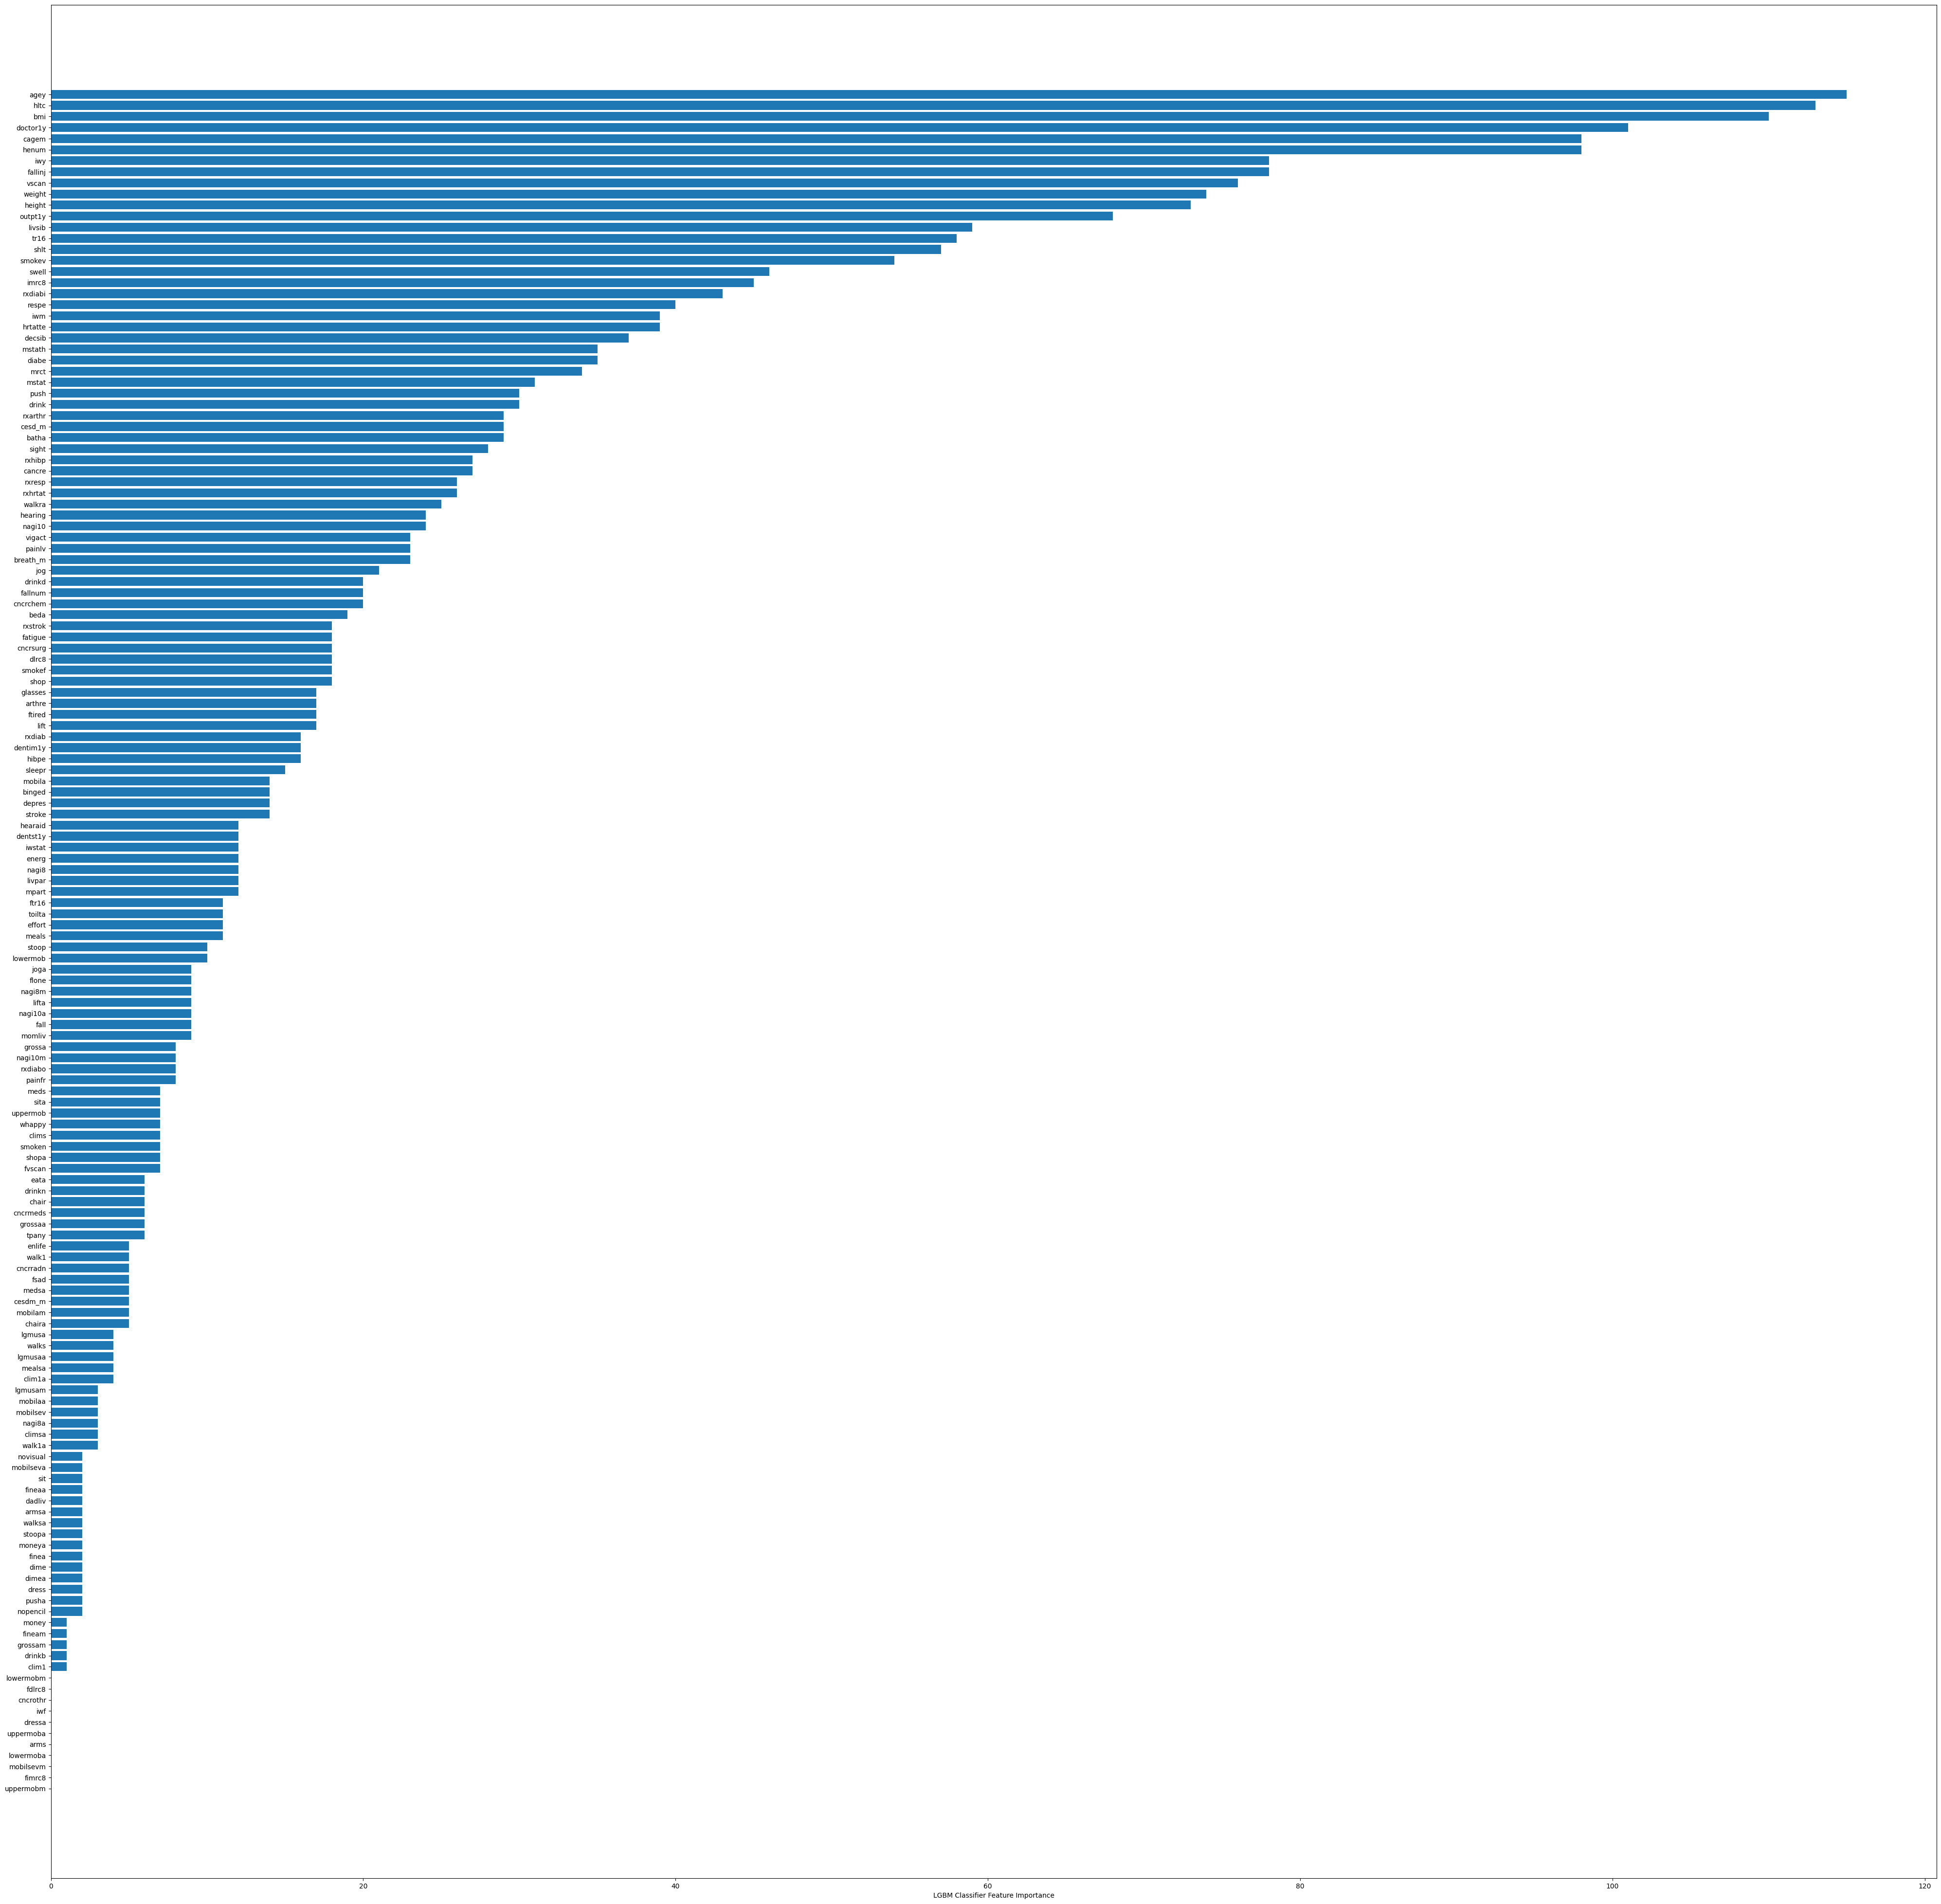

In [31]:
plt.figure(figsize=(50, 50)) # Set the size of the figure
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("LGBM Classifier Feature Importance")
plt.show()

Now we perform the prediction of both training and validation variables; this will allow us to calculate the ROC-AUC metric of the implemented model.

In [32]:
# Train data predictions (class 1)
rf_pred_train = model.predict_proba(X_train)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = model.predict_proba(X_test)[:, 1]
# Train ROC AUC Score

roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_test, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.9661
Validation ROC AUC Score: 0.7776


Based on the metrics and the confusion matrix, we can determine that our model is not the best, so we decided to perform another search.

In [33]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     21971
         1.0       0.52      0.19      0.28      2902

    accuracy                           0.88     24873
   macro avg       0.71      0.58      0.61     24873
weighted avg       0.86      0.88      0.86     24873



In [34]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[21444   527]
 [ 2340   562]]


## 4. Training of a Random Forest model
In our case, the Random Forest model was the best fit for the training data because a more robust hyperparameter search was applied.

The first thing we do is to select the 50 features that best perform the model with LGBM. 

In [35]:
slice_length = 50

start_index = max(len(X_train.columns) - slice_length, 0)

top50_features = X_train.columns[sorted_idx][:-slice_length-1:-1]

print(top50_features.tolist())

['agey', 'hltc', 'bmi', 'doctor1y', 'cagem', 'henum', 'iwy', 'fallinj', 'vscan', 'weight', 'height', 'outpt1y', 'livsib', 'tr16', 'shlt', 'smokev', 'swell', 'imrc8', 'rxdiabi', 'respe', 'iwm', 'hrtatte', 'decsib', 'mstath', 'diabe', 'mrct', 'mstat', 'push', 'drink', 'rxarthr', 'cesd_m', 'batha', 'sight', 'rxhibp', 'cancre', 'rxresp', 'rxhrtat', 'walkra', 'hearing', 'nagi10', 'vigact', 'painlv', 'breath_m', 'jog', 'drinkd', 'fallnum', 'cncrchem', 'beda', 'rxstrok', 'fatigue']


Now, we create the Random Forest model and generate the search for hyperparameters that best fit the data and the model. 

In [36]:
param_dist = {
    "max_depth": [3, 5, None], 
    "max_features": [0.2, 0.6, 1.0], 
    "min_samples_split": [2, 5], 
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [20, 60, 100],
    "min_samples_leaf": [1, 2]
} 

roc_auc_scorer = make_scorer(roc_auc_score)

rf = RandomForestClassifier()
model = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=roc_auc_scorer, verbose=2, n_jobs=-1) 
model.fit(X_train[top50_features.tolist()], y_train)

# Train data predictions (class 1)
rf_pred_train = model.predict_proba(X_train[top50_features.tolist()])[:, 1]

# Validation data predictions (class 1)
rf_pred_val = model.predict_proba(X_test[top50_features.tolist()])[:, 1]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Finally, based on the metrics and the confusion matrix, we can determine that our model achieves a metric of 94% for our target variable, so we decided to work with this model.

In [37]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_test, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9428


In [38]:
y_pred = model.predict(X_test[top50_features.tolist()])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     21971
         1.0       0.96      0.59      0.73      2902

    accuracy                           0.95     24873
   macro avg       0.96      0.79      0.85     24873
weighted avg       0.95      0.95      0.94     24873



In [39]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[21906    65]
 [ 1193  1709]]


We import the model using pickle

In [40]:
# Save the model to a file
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [41]:
# To load your model from the file
loaded_model = joblib.load('random_forest_model.pkl')